<a href="https://colab.research.google.com/github/yudumpacin/Earthquakes-in-Turkey/blob/main/Kandilli_Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Earthquakes in Turkey**

Kandilli Rasathanesi webpage gives information about last 500 earthquakes in Turkey and near Turkey, these information is updated regularly. I will analyze this data using Pyhton libraries.

In [1073]:
#Necessary Libraries are imported
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests as req
import matplotlib.pyplot as plt
import seaborn as sn
import folium
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
import os.path, time, datetime
from sklearn.ensemble import IsolationForest
from scipy import stats


Last Runtime:

In [1074]:
import datetime
now = datetime.datetime.utcnow()+datetime.timedelta(hours=3)
last_modified_time = now.strftime("%Y-%m-%d %H:%M:%S")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

2021-06-26 20:11:24


# 1- Data

Earthquake data is extracted from Kandilli Rasathanesi wep page.
Data consists of last 500 earthquake happened in Turkey. Each data sample has these features; 
* Tarih (date), 
* Enlem (latitude), 
* Boylam (longtitude), 
* Derinlik(depth), 
* ML(magnitute), 
* Yer(name of place), and 
* Çözüm Niteliği (attribute of solution (primary,revised))

### Extract the  Data from webpage

In [1075]:
# I will extract data with Beautifoulsoup and request library
link = 'http://www.koeri.boun.edu.tr/scripts/lst5.asp'
re = req.get(link)
soup = bs(re.content)

In [1076]:
data_all = soup.find('pre').get_text().split('\r\n')

In [1077]:
feature = data_all[5:6]

In [1078]:
data = data_all[7:]

In [1079]:
data[:5]

['2021.06.26 19:29:54  39.2023   40.2452       12.5      -.-  2.1  -.-   BILEKKAYA-YAYLADERE (BINGOL)                      İlksel',
 '2021.06.26 19:06:00  36.3197   27.0857       11.4      -.-  2.1  -.-   AKDENIZ                                           İlksel',
 '2021.06.26 19:02:58  36.3338   27.0217        5.0      -.-  2.8  -.-   AKDENIZ                                           İlksel',
 '2021.06.26 18:56:17  37.8430   26.8203        8.9      -.-  1.8  -.-   EGE DENIZI                                        İlksel',
 '2021.06.26 18:52:56  37.8987   26.8812        4.9      -.-  2.1  -.-   KUSADASI KORFEZI (EGE DENIZI)                     İlksel']

In [1080]:
feature

['Tarih      Saat      Enlem(N)  Boylam(E) Derinlik(km)  MD   ML   Mw    Yer                                             Çözüm Niteliği']

In [1081]:
#drop "çözüm niteliği" feature, since  çözüm niteliği (attribute of solution ), it is whether primary, i.e. the info is given without revized, or revized
feature = ['Tarih' ,'Saat' , 'Enlem(N)'  ,'Boylam(E)','Derinlik(km)','MD','ML','Mw','Yer']

In [1082]:
df = pd.DataFrame(data)

In [1083]:
df = df[0].str.split(' ', expand=True)

In [1084]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,2021.06.26,19:29:54,,39.2023,,,40.2452,,,,,,,12.5,,,,,,-.-,,2.1,,-.-,,,BILEKKAYA-YAYLADERE,(BINGOL),,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2021.06.26,19:06:00,,36.3197,,,27.0857,,,,,,,11.4,,,,,,-.-,,2.1,,-.-,,,AKDENIZ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None
2,2021.06.26,19:02:58,,36.3338,,,27.0217,,,,,,,,5.0,,,,,,-.-,,2.8,,-.-,,,AKDENIZ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None
3,2021.06.26,18:56:17,,37.8430,,,26.8203,,,,,,,,8.9,,,,,,-.-,,1.8,,-.-,,,EGE,DENIZI,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None
4,2021.06.26,18:52:56,,37.8987,,,26.8812,,,,,,,,4.9,,,,,,-.-,,2.1,,-.-,,,KUSADASI,KORFEZI,(EGE,DENIZI),,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [1085]:
df = df.iloc[:,:29]

In [1086]:
df.drop([2,4,5,7,	8	,9,	10,	11	,12,15,	16	,17,	18],axis=1,inplace=True)
df[13] = df[13]+df[14]
df[19] = df[19]+df[20]
df[21] = df[21]+df[22]
df[23] = df[23]+df[24]
df[26] = df[26]+' '+df[27]+' '+df[28]

In [1087]:
df.drop([14],axis=1,inplace=True)
df.drop([20],axis=1,inplace=True)
df.drop([22],axis=1,inplace=True)
df.drop([24],axis=1,inplace=True)
df.drop([25],axis=1,inplace=True)
df.drop([27],axis=1,inplace=True)
df.drop([28],axis=1,inplace=True)

In [1088]:
df.columns=feature

In [1089]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),MD,ML,Mw,Yer
0,2021.06.26,19:29:54,39.2023,40.2452,12.5,-.-,2.1,-.-,BILEKKAYA-YAYLADERE (BINGOL)
1,2021.06.26,19:06:00,36.3197,27.0857,11.4,-.-,2.1,-.-,AKDENIZ
2,2021.06.26,19:02:58,36.3338,27.0217,5.0,-.-,2.8,-.-,AKDENIZ
3,2021.06.26,18:56:17,37.8430,26.8203,8.9,-.-,1.8,-.-,EGE DENIZI
4,2021.06.26,18:52:56,37.8987,26.8812,4.9,-.-,2.1,-.-,KUSADASI KORFEZI


# 2. Preprocessing

In [1090]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tarih         502 non-null    object
 1   Saat          500 non-null    object
 2   Enlem(N)      500 non-null    object
 3   Boylam(E)     500 non-null    object
 4   Derinlik(km)  500 non-null    object
 5   MD            500 non-null    object
 6   ML            500 non-null    object
 7   Mw            500 non-null    object
 8   Yer           500 non-null    object
dtypes: object(9)
memory usage: 35.4+ KB


In [1091]:
df.replace('-.-',np.NAN,inplace=True)

In [1092]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tarih         502 non-null    object
 1   Saat          500 non-null    object
 2   Enlem(N)      500 non-null    object
 3   Boylam(E)     500 non-null    object
 4   Derinlik(km)  500 non-null    object
 5   MD            1 non-null      object
 6   ML            499 non-null    object
 7   Mw            17 non-null     object
 8   Yer           500 non-null    object
dtypes: object(9)
memory usage: 35.4+ KB


In [1093]:
#MD and Mw values are mostly null, so drop these two columns from dataframe
df.drop(['MD','Mw'],axis=1,inplace=True)

In [1094]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),ML,Yer
0,2021.06.26,19:29:54,39.2023,40.2452,12.5,2.1,BILEKKAYA-YAYLADERE (BINGOL)
1,2021.06.26,19:06:00,36.3197,27.0857,11.4,2.1,AKDENIZ
2,2021.06.26,19:02:58,36.3338,27.0217,5.0,2.8,AKDENIZ
3,2021.06.26,18:56:17,37.8430,26.8203,8.9,1.8,EGE DENIZI
4,2021.06.26,18:52:56,37.8987,26.8812,4.9,2.1,KUSADASI KORFEZI


In [1095]:
#convert numerical features
df['Enlem(N)'] = pd.to_numeric(df['Enlem(N)'])
df['Boylam(E)'] = pd.to_numeric(df['Boylam(E)'])
df['Derinlik(km)'] = pd.to_numeric(df['Derinlik(km)'])
df['ML'] = pd.to_numeric(df['ML'])

In [1096]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tarih         502 non-null    object 
 1   Saat          500 non-null    object 
 2   Enlem(N)      500 non-null    float64
 3   Boylam(E)     500 non-null    float64
 4   Derinlik(km)  499 non-null    float64
 5   ML            499 non-null    float64
 6   Yer           500 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.6+ KB


In [1097]:
#convert date feature
df['TarihSaat'] = df['Tarih'] +' '+ df['Saat']
df['TarihSaat'] = pd.to_datetime(df['TarihSaat'])

In [1098]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),ML,Yer,TarihSaat
0,2021.06.26,19:29:54,39.2023,40.2452,12.5,2.1,BILEKKAYA-YAYLADERE (BINGOL),2021-06-26 19:29:54
1,2021.06.26,19:06:00,36.3197,27.0857,11.4,2.1,AKDENIZ,2021-06-26 19:06:00
2,2021.06.26,19:02:58,36.3338,27.0217,5.0,2.8,AKDENIZ,2021-06-26 19:02:58
3,2021.06.26,18:56:17,37.8430,26.8203,8.9,1.8,EGE DENIZI,2021-06-26 18:56:17
4,2021.06.26,18:52:56,37.8987,26.8812,4.9,2.1,KUSADASI KORFEZI,2021-06-26 18:52:56


In [1099]:
df['Date'] = pd.to_datetime(df['TarihSaat'])
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['hour'] = pd.DatetimeIndex(df['Date']).hour
df['minute'] = pd.DatetimeIndex(df['Date']).minute
df['seconds'] = pd.DatetimeIndex(df['Date']).second

In [1100]:
df = df.drop(['Tarih','Saat','Date'], axis = 1) 

In [1101]:
df.isna().sum()

Enlem(N)        2
Boylam(E)       2
Derinlik(km)    3
ML              3
Yer             2
TarihSaat       2
year            2
month           2
day             2
hour            2
minute          2
seconds         2
dtype: int64

In [1102]:
df = df.dropna()

# 2. EDA (Exploratory Data Analysis)


In [1103]:
df.head()

,Enlem(N),Boylam(E),Derinlik(km),ML,Yer,TarihSaat,year,month,day,hour,minute,seconds
0,39.2023,40.2452,12.5,2.1,BILEKKAYA-YAYLADERE (BINGOL),2021-06-26 19:29:54,2021.0,6.0,26.0,19.0,29.0,54.0
1,36.3197,27.0857,11.4,2.1,AKDENIZ,2021-06-26 19:06:00,2021.0,6.0,26.0,19.0,6.0,0.0
2,36.3338,27.0217,5.0,2.8,AKDENIZ,2021-06-26 19:02:58,2021.0,6.0,26.0,19.0,2.0,58.0
3,37.8430,26.8203,8.9,1.8,EGE DENIZI,2021-06-26 18:56:17,2021.0,6.0,26.0,18.0,56.0,17.0
4,37.8987,26.8812,4.9,2.1,KUSADASI KORFEZI,2021-06-26 18:52:56,2021.0,6.0,26.0,18.0,52.0,56.0


In [1104]:
print(f'There are {df.shape[0]} earthquakes between {max(df.TarihSaat)-min(df.TarihSaat)} in {len(df.Yer.value_counts())} different places near Turkey')

There are 499 earthquakes between 3 days 21:23:34 in 125 different places near Turkey



ONIKI ADALAR (AKDENIZ) is the place where most earthquakes happen, but the mean of ML is 1.9, that is small magnitute earthquakes take place in this reagon frequently

In [1105]:
df.groupby(df['Yer'])['ML'].describe().sort_values(by = 'count', ascending= False)[0:10]

,count,mean,std,min,25%,50%,75%,max
Yer,,,,,,,,
ONIKI ADALAR (AKDENIZ),93.0,1.906452,0.259936,1.4,1.700,1.90,2.100,2.6
AKDENIZ,84.0,2.263095,0.486883,1.5,1.900,2.15,2.525,3.9
ONIKI ADALAR,72.0,1.995833,0.345774,1.3,1.700,2.00,2.200,3.1
AKDENIZ,71.0,2.040845,0.400563,1.3,1.750,2.00,2.300,3.1
KUSADASI KORFEZI,14.0,1.971429,0.441028,1.3,1.600,2.00,2.100,2.7
EGE DENIZI,8.0,1.950000,0.307060,1.6,1.775,1.90,2.025,2.6
EGE DENIZI,6.0,1.966667,0.581951,1.6,1.600,1.75,1.975,3.1
KUSBAYIRI-KARAKOCAN (ELAZIG),6.0,2.150000,0.378153,1.6,1.900,2.25,2.375,2.6
KUSBAYIRI-KARAKOCAN (ELAZIG),5.0,2.960000,1.310725,2.3,2.300,2.40,2.500,5.3


Now, explore earthquakes bigger than 2 ML, this time AKDENİZ region is the place where most earthquakes happen

In [1106]:
df[df.ML>2].groupby(df['Yer'])['ML'].describe().sort_values(by = 'count', ascending= False)[0:10]

,count,mean,std,min,25%,50%,75%,max
Yer,,,,,,,,
AKDENIZ,50.0,2.556000,0.410157,2.1,2.200,2.50,2.800,3.9
AKDENIZ,34.0,2.382353,0.273552,2.1,2.200,2.30,2.600,3.1
ONIKI ADALAR,32.0,2.303125,0.253345,2.1,2.100,2.20,2.425,3.1
ONIKI ADALAR (AKDENIZ),26.0,2.230769,0.166779,2.1,2.100,2.20,2.300,2.6
KUSADASI KORFEZI,6.0,2.350000,0.294958,2.1,2.100,2.25,2.625,2.7
KUSBAYIRI-KARAKOCAN (ELAZIG),5.0,2.960000,1.310725,2.3,2.300,2.40,2.500,5.3
KUSBAYIRI-KARAKOCAN (ELAZIG),4.0,2.375000,0.170783,2.2,2.275,2.35,2.450,2.6
BILEKKAYA-YAYLADERE (BINGOL),3.0,2.333333,0.321455,2.1,2.150,2.20,2.450,2.7
EGE DENIZI,2.0,2.350000,0.353553,2.1,2.225,2.35,2.475,2.6


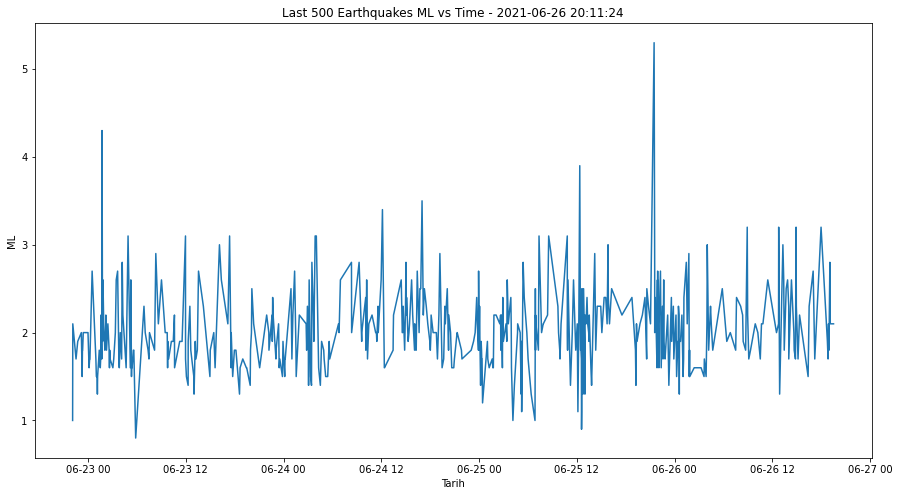

In [1107]:
plt.figure(figsize=(15,8))
plt.plot(df['TarihSaat'], df['ML'])
plt.xlabel('Tarih')
plt.ylabel('ML')
plt.title(f'Last 500 Earthquakes ML vs Time - {last_modified_time}')
plt.show()


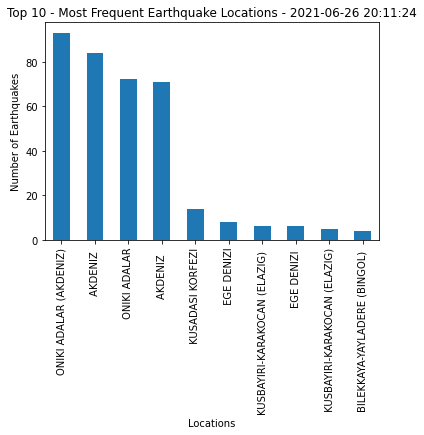

In [1108]:
df['Yer'].value_counts().sort_values(ascending=False)[0:10].plot(kind='bar')
plt.title(f'Top 10 - Most Frequent Earthquake Locations - {last_modified_time}')
plt.ylabel('Number of Earthquakes')
plt.xlabel('Locations')
plt.show()

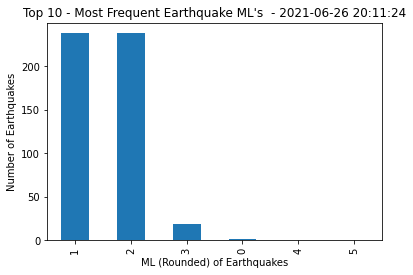

In [1109]:
df['ML'].astype(int).value_counts().sort_values(ascending=False)[0:10].plot(kind='bar')
plt.title(f'Top 10 - Most Frequent Earthquake ML\'s  - {last_modified_time}')
plt.ylabel('Number of Earthquakes')
plt.xlabel('ML (Rounded) of Earthquakes')
plt.show()

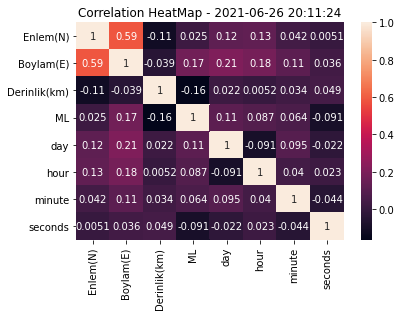

In [1110]:
corr = df.drop(['Yer','year','month'],axis=1).corr()
sn.heatmap(corr,annot=True)
plt.title(f'Correlation HeatMap - {last_modified_time}')
plt.show()

Correlation heatmap shows, there is not a strong realtionship between features.
Maximum correlation ranks belong to Langitute, longtitue features, this can be due to the earthquakes happen in the east of th country at that time, we extract the Data (2021-06-26)

## 2.1 Outliers

### 2.1.1 Isolation Forest

Find outlier earthquake samples in the dataset by IsolationForest

In [1111]:
isf = IsolationForest()

In [1112]:
X= df.drop(['TarihSaat','Yer'],axis=1)

In [1113]:
isf.fit(X)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [1114]:
outliers = np.where(isf.predict(X)==-1)[0]

In [1115]:
df['isoutlier'] =0
df.iloc[outliers,-1] =1

In [1116]:
df.head()

,Enlem(N),Boylam(E),Derinlik(km),ML,Yer,TarihSaat,year,month,day,hour,minute,seconds,isoutlier
0,39.2023,40.2452,12.5,2.1,BILEKKAYA-YAYLADERE (BINGOL),2021-06-26 19:29:54,2021.0,6.0,26.0,19.0,29.0,54.0,1
1,36.3197,27.0857,11.4,2.1,AKDENIZ,2021-06-26 19:06:00,2021.0,6.0,26.0,19.0,6.0,0.0,0
2,36.3338,27.0217,5.0,2.8,AKDENIZ,2021-06-26 19:02:58,2021.0,6.0,26.0,19.0,2.0,58.0,1
3,37.8430,26.8203,8.9,1.8,EGE DENIZI,2021-06-26 18:56:17,2021.0,6.0,26.0,18.0,56.0,17.0,0
4,37.8987,26.8812,4.9,2.1,KUSADASI KORFEZI,2021-06-26 18:52:56,2021.0,6.0,26.0,18.0,52.0,56.0,1


In [1117]:
def createMap(df):
  latitude = df['Enlem(N)'].mean()
  longitude = df['Boylam(E)'].mean()
  colurs = ['#0000FF','#FF0000']
  # create map
  map_earthquakes = folium.Map(location=[latitude,longitude],zoom_start=7)
  # add markers to the map
  markers_colors = []
  for lat, lon, yer, derinlik, ml,zaman, outlier in zip(df['Enlem(N)'], df['Boylam(E)'],df['Yer'] ,df['Derinlik(km)'],df['ML'],df['TarihSaat'],df['isoutlier']):
    label = folium.Popup( parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5*ml,
        popup="Yer:"+ str(yer)+"\nTarih:"+str(zaman)+"\nŞiddet:"+str(ml) +"\nDerinlik:"+str(derinlik),
        color=colurs[outlier],
        fill_color=colurs[outlier],
        fill=True,
        fill_opacity=0.7).add_to(map_earthquakes)
  print(f'Last 500 Earthquakes in (or near) Turkey - {last_modified_time}')
  return map_earthquakes

**Outlier Detection with Isolation Forest**

In [1118]:
createMap(df)

Last 500 Earthquakes in (or near) Turkey - 2021-06-26 20:11:24


In the map, each point represents an Eartquake,
the red points are outliers.
ML determines the radius of points. Bigger earthquakes are represented bigger points.

### 2.1.2 IQR

In [1119]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
alt_sinir = Q1- 1.5*IQR
ust_sinir = Q3 + 1.5*IQR


In [1120]:
alt_sinir

Enlem(N)          33.994600
Boylam(E)         26.608425
Derinlik(km)      -9.300000
ML                 0.950000
year            2021.000000
month              6.000000
day               20.000000
hour             -15.500000
minute           -28.250000
seconds          -31.500000
dtype: float64

In [1121]:
ust_sinir

Enlem(N)          40.165400
Boylam(E)         27.839825
Derinlik(km)      29.900000
ML                 2.950000
year            2021.000000
month              6.000000
day               28.000000
hour              36.500000
minute            89.750000
seconds           92.500000
dtype: float64

In [1122]:
outliers = np.where((X < alt_sinir) | (X > ust_sinir))[0] #altsınırdan küçük ve üstsınırdan büyük verilere sahip satırlar outlier olarak sınıflandırılır

In [1123]:
df['isoutlier'] =0
df.iloc[outliers,-1] =1

**Outlier Detection with IQR**

In [1124]:
createMap(df)

Last 500 Earthquakes in (or near) Turkey - 2021-06-26 20:11:24


### 2.1.3 Z-Score

In [1125]:
outliers = np.where(np.abs(stats.zscore(X))>3)[0]

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [1126]:
df['isoutlier'] =0
df.iloc[outliers,-1] =1

**Outlier Detection with Z-Score**

In [1127]:
createMap(df)

Last 500 Earthquakes in (or near) Turkey - 2021-06-26 20:11:24


# 3. ML Application

First, I will try to predict ML of the data with linear and ensemble models

* Linear Regression Model

In [1128]:
y = df['ML']
X = df.drop(['TarihSaat','Yer','ML','isoutlier'],axis=1)

In [1129]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [1130]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

In [1131]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print('Linear Regression Model mean squares error is: ',mean_squared_error(y_test,y_pred))
print('Linear Regression Model R^2 is: ',lr.score(X_test,y_test))

Linear Regression Model mean squares error is:  0.1717189193700674
Linear Regression Model R^2 is:  0.08880946033216985


In [1132]:
weighs = lr.coef_
features=X.columns

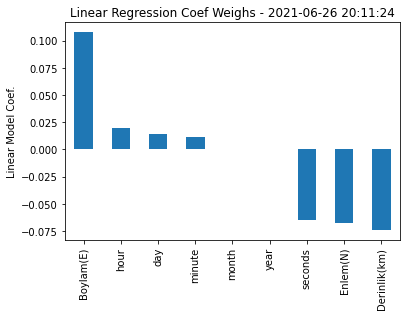

In [1133]:
pd.Series(weighs, index=features).sort_values(ascending=False).plot(kind='bar')
plt.title(f'Linear Regression Coef Weighs - {last_modified_time}')
plt.ylabel('Linear Model Coef.')
plt.show()

Boylam(E)-Longitute effects ML positively. This is due to the last big earthquakes happen in the east of Turkey (Elazığ,5.3) soon.

Derinlik(km)-Depth effects ML negatively. Shallow earthquakes, make bigger ML. This can be also the feature of last earthquakes only

Enlem(N)-Latitude effects ML negatively, norther locations have smaller ML earthquakes locations in Turkey

* Random Forest Regression Model

In [1134]:
y = df['ML']
X = df.drop(['TarihSaat','Yer','ML'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

In [1135]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print('Random Forest Regression Model mean squares error is: ',mean_squared_error(y_test,y_pred))
print('Random Forest Regression Model R^2 is: ',rfr.score(X_test,y_test))

Random Forest Regression Model mean squares error is:  0.28782824000000024
Random Forest Regression Model R^2 is:  -0.5273003714403646


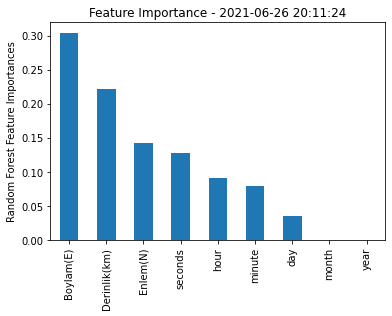

In [1136]:
pd.Series(rfr.feature_importances_, index=features).sort_values(ascending=False).plot(kind='bar')
plt.title(f'Feature Importance - {last_modified_time}')
plt.ylabel('Random Forest Feature Importances')
plt.show()

Similar to linear model, boylam(E)-longitute is the strongest feature effecting ML, This result shows the location features of last earthquakes